In [2]:
import pynwb
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt


### Define behavioral classes to represent track

In [3]:
class BehavioralPoint():
    def __init__(self, center_point, name):
        self.x = center_point[0]
        self.y = center_point[1]
        self.name = name
    
class BehavioralPath():
    def __init__(self, segment, name):
        self.segment = segment
        self.name = name

class BehavioralArea():
    def __init__(self, polygon, name):
        self.polygon = polygon
        self.name = name


### Make behavioral objects for W-track

In [20]:
# W-track path segments
wtrack_L = BehavioralPath([(1.6, 2.25), (1.6, 0.65)], "L")
wtrack_LC = BehavioralPath([(1.6, 0.65), (1.9, 0.65)], "LC")
wtrack_C = BehavioralPath([(1.9, 0.65), (1.9, 2.25)], "C")
wtrack_RC = BehavioralPath([(1.9, 0.65), (2.25, 0.65)], "RC")
wtrack_R = BehavioralPath([(2.25, 0.65), (2.25, 2.25)], "R")
all_paths = [wtrack_L, wtrack_LC, wtrack_C, wtrack_RC, wtrack_R]

# W-track points (wells)
wtrack_wL = BehavioralPoint((1.6, 2.25), "LW")
wtrack_wC = BehavioralPoint((1.9, 2.25), "CW")
wtrack_wR = BehavioralPoint((2.25, 2.25), "RW")
all_points = [wtrack_wL, wtrack_wC, wtrack_wR]

## Build graph for W-track
Here we are duplicating some information in the graph nodes that is also in the behavioral objects (e.g. 'name'). This makes graph operations simpler (i.e. drawing a graph with nodes labeled by 'name') and allows encapuslation of info about each node, but we get this at the expense of the possibility of degeneracy and complexity. Another option is to not use the behavioral objects, and instead just put all relevant information as graph attributes. We will explore this further [below](#no_objects).

### Add nodes

In [5]:
G = nx.Graph(name='w-track')

# Add nodes to the graph
# ----------------------
# Track segments
for path in all_paths:
    G.add_node(path, name=path.name, kind='path')
# Wells
for pt in all_points:
    G.add_node(pt, name=pt.name, kind='point')

### Add edges (corresponding to the W-track topology)

In [5]:
# Add edges connecting the appropriate nodes
# -----------------------------------------
# Segment <-> Segment
G.add_edge(wtrack_L, wtrack_LC)
G.add_edge(wtrack_LC, wtrack_C)
G.add_edge(wtrack_RC, wtrack_C)
G.add_edge(wtrack_LC, wtrack_RC)
G.add_edge(wtrack_RC, wtrack_R)
# Segment <-> Well
G.add_edge(wtrack_L, wtrack_wL)
G.add_edge(wtrack_C, wtrack_wC)
G.add_edge(wtrack_R, wtrack_wR)

### Plot track topology

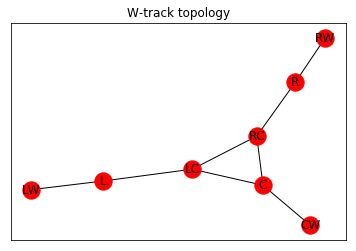

In [6]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology")
nx.draw_networkx(G, labels=dict(G.nodes.data('name')), fontsize=6)


### Plot track geometry

Text(0,0.5,'y pos (meters)')

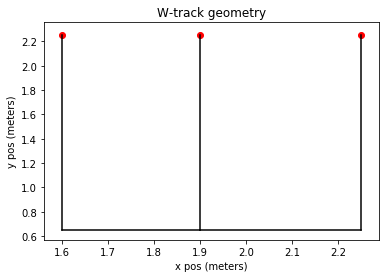

In [7]:
ax = plt.subplot(111)
plt.title('W-track geometry')
for n, attrs in list(G.nodes.data()):
    if attrs['kind']=='point':
        plt.scatter([n.x], [n.y], color='r')
    if attrs['kind']=='path':
        start = n.segment[0]
        end = n.segment[1]
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')

<a name='no_objects'></a>
### Alternate: Do not use behavioral objects. Store all metadata in graph attrs.
As discussed above, having behavioral objects encapsulates the data at the expense of introducing some degeneracy in the metadata. Instead, we can have graph nodes be arbitary integers, with all metadata contained as graph attributes.  

In [39]:
H = nx.convert_node_labels_to_integers(G)
print("Note that we have lost information about the geometry of the points and paths!")
print("These data were in the behavioral objects...\n")
list(H.nodes.data())

Note that we have lost information about the geometry of the points and paths!
These data were in the behavioral objects...



[(0, {'name': 'L', 'kind': 'path'}),
 (1, {'name': 'LC', 'kind': 'path'}),
 (2, {'name': 'C', 'kind': 'path'}),
 (3, {'name': 'RC', 'kind': 'path'}),
 (4, {'name': 'R', 'kind': 'path'}),
 (5, {'name': 'LW', 'kind': 'point'}),
 (6, {'name': 'CW', 'kind': 'point'}),
 (7, {'name': 'RW', 'kind': 'point'})]

### Recover the geometry metadata and store in the graph attrs

In [37]:
name_list = [e[1] for e in list(H.nodes.data('name'))]  # list of names of each node, in index order

# For path objects, store the [(x1, y1), (x2, y2)] of the segment start and end points
for path in all_paths:
    idx = name_list.index(path.name)
    H.nodes[idx]['segment'] = path.segment
    
# For point objects, store the (x, y) coordinate of the point
for pt in all_points:
    idx = name_list.index(pt.name)
    H.nodes[idx]['coord'] = (pt.x, pt.y)

print("Now we have the geometry metadata in the graph attributes: \n")
list(H.nodes.data())

Now we have the geometry metadata in the graph attributes: 



[(0, {'name': 'L', 'kind': 'path', 'segment': [(1.6, 2.25), (1.6, 0.65)]}),
 (1, {'name': 'LC', 'kind': 'path', 'segment': [(1.6, 0.65), (1.9, 0.65)]}),
 (2, {'name': 'C', 'kind': 'path', 'segment': [(1.9, 0.65), (1.9, 2.25)]}),
 (3, {'name': 'RC', 'kind': 'path', 'segment': [(1.9, 0.65), (2.25, 0.65)]}),
 (4, {'name': 'R', 'kind': 'path', 'segment': [(2.25, 0.65), (2.25, 2.25)]}),
 (5, {'name': 'LW', 'kind': 'point', 'coord': (1.6, 2.25)}),
 (6, {'name': 'CW', 'kind': 'point', 'coord': (1.9, 2.25)}),
 (7, {'name': 'RW', 'kind': 'point', 'coord': (2.25, 2.25)})]

### Plot track topology (no behavioral objects)

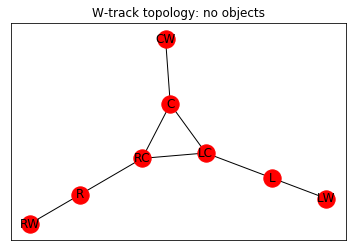

In [16]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology: no objects")
nx.draw_networkx(H, labels=dict(H.nodes.data('name')), fontsize=6)

### Plot track geometry (no behavioral objects)

In [ ]:
ax = plt.subplot(111)
plt.title('W-track geometry (no objects)')
for n, attrs in list(G.nodes.data()):
    if attrs['kind']=='point':
        coord = attrs['coord']
        plt.scatter([coord.x], [coord.y], color='r')
    if attrs['kind']=='path':
        start, end = attrs['segment']
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')